In [1]:
import os
import pandas
import matplotlib.pyplot as plt 
from IPython.display import Image, display

Hi Hani,

I have just sent you the Box folder for our fastq files. We have 6 different conditions here with triplicates:
- KO-C (KO control)
- KO-T (KO treated)
- AD-C (addback control)
- AD-T (addback treated)
- pMXS_T (KO tumors)
- ATG7_T (addback tumors)

Our initial analysis gave us a really weird volcano plot as attached and we were not sure what the problem was.
It will be great if you can help us re-analyse. These are mouse cells so the alignment should be to mouse.

For the differential comparisons, we would like to compare:
- AD-C vs AD-T
- AD-C vs KO-C
- AD-T vs KO-T
- AD-C vs ATG7_T
- ATG7_T vs pMXS_T

Let me know if you need any other information. Thank you so much for your help.

In [ ]:
%%bash
ls fastq/*.fastq.gz

### Trimming task

In [ ]:
if not os.path.exists('./qc_fastq'):
    os.mkdir('HIV_bam')

In [ ]:
%%bash
# fastq QC 
for f in fastq/*.fastq.gz; do
    fastqc -f fastq --noextract -t 12 -o qc_fastq/ ./$f;
done

In [ ]:
# %%bash
# # Trimming task
# for f in *.fastq.gz; do
#     out=${f/R1_001.fastq.gz/trim.fastq.gz};     
#     echo cutadapt -u 3 -j 12 -q 15 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -o $out $f;
# done

### Alignment task

In [5]:
if not os.path.exists('./bam'):
    os.mkdir('bam')

In [ ]:
%%bash
for f in fastq/*fastq.gz; do
    echo $f;
    out=${f/_R1_001.fastq.gz/_};
    out=${out/fastq/bam};
    STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand zcat --runThreadN 8 --sjdbGTFfile /rumi/shams/genomes/mm10/mm10_ensemble_genes.gtf --genomeDir /rumi/shams/genomes/mm10 --readFilesIn $f --outFileNamePrefix $out;
done&

In [2]:
%%bash
ls 

bam
fastq
feature_counts
notebook.ipynb
qc_fastq
results


### Measure counts

In [6]:
if not os.path.exists('./feature_counts'):
    os.mkdir('feature_counts')

In [ ]:
%%bash
for f in bam/*.out.bam; do
    out=${f/_S*/.gene.fc};
    out=${out/bam/feature_counts};
    featureCounts -T 12 -P -B -C -O -t exon -g gene_name -a /rumi/shams/genomes/mm10/mm10_ensemble_genes.gtf -o $out $f;
done&

### Models
1. AD-C vs AD-T
2. AD-C vs KO-C
3. AD-T vs KO-T
4. AD-C vs ATG7_T
5. ATG7_T vs pMXS_T

In [ ]:
if not os.path.exists('./results'):
    os.mkdir('results')
if not os.path.exists('./results/plots'):
    os.mkdir('results/plots')

Move to R:

In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(DESeq2,quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(NOISeq, quietly = TRUE)
library(EnhancedVolcano, quietly = TRUE)
library(dplyr)
library(refGenome)
library(pheatmap)

In [4]:
%%R
# meta data
sample.type <- c(rep("AD",6), rep("ATG7",3), rep("KO",6), rep("pMXS",3))
sample.cond <- c(rep('C',3), rep('T',3), rep('T',3), rep('C',3), rep('T',3), rep('T',3))
replicate <- c(rep(c('1','2','3'),6))
all_cond <- paste(sample.type, paste (sample.cond, replicate, sep=""), sep="_")
conds <- paste(sample.type, sample.cond, sep="_")
# models 
model_1 = c("AD_C", "AD_T")
model_2 = c("AD_C", "KO_C")
model_3 = c("AD_T", "KO_T")
model_4 = c("AD_C", "ATG7_T")
model_5 = c("ATG7_T", "pMXS_T")
## read count files 
files <- list.files(path="feature_counts" , pattern=".fc$")
datalist <- lapply(files, function(x){read.table(file=paste('feature_counts/',x, sep = ''),header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m)<- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- all_cond
# gene list HALLMARK_TNFA_SIGNALING_VIA_NFKB
gene_set <- read.table('../geneset.txt', header = T, sep = ",", 
                       stringsAsFactors = F)$HALLMARK_TNFA_SIGNALING_VIA_NFKB[-c(1,2)]
mm_set <- read.delim('../MouseHumanSequence.rpt.parsed.symbols.txt', header = F, sep = "\t", stringsAsFactors = F)
mm_set <- data.frame('mm' = mm_set$V2, row.names = mm_set$V1, stringsAsFactors = F)[gene_set,]
mm_set <- mm_set[!is.na(mm_set)]

# RNA-Seq QC
### PCA and Heatmap

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: Saving 6.67 x 6.67 in image



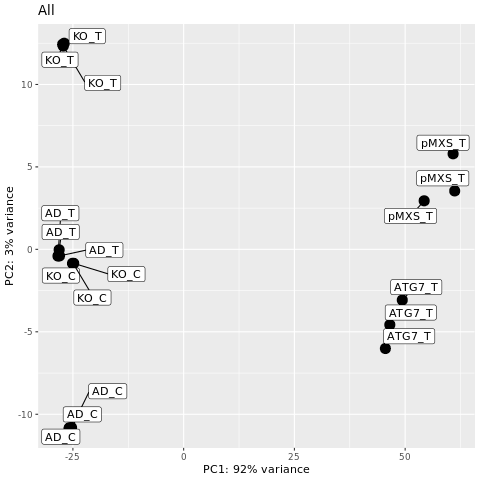

In [5]:
%%R
colData <- data.frame(conds, row.names=colnames(m))
dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ conds)
dds <- DESeq(dds)
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)

## PCA Plot 
z <- plotPCA(vsd,intgroup=c("conds"), returnData=TRUE)
percentVar <- round(100 * attr(z, "percentVar"))
p <- ggplot(z, aes(PC1, PC2)) +
  geom_point(aes(size = 4)) +
  ggtitle('All') + 
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  geom_label_repel(label = conds, force = 10) +
  guides(size = FALSE)
ggsave(paste('results/plots/PCA.pdf',sep=''), plot = p, device = 'pdf', dpi = 300)
print(p)

In [70]:
# %%R
# dds <- estimateSizeFactors(dds)
# sizeFactors(dds)
# # log transformation
# vsd <- vst(dds, blind=TRUE)
# # Extract the vst matrix from the object
# vsd_mat <- assay(vsd)

In [69]:
# %%R
# df <- vsd_mat[mm_set [mm_set %in% row.names(vsd_mat)] , ]
# in_vivo  <- unlist(lapply (c('pMXS', 'ATG7'),grep, colnames(df) ))
# in_vitro <- unlist(lapply (c('AD', 'KO'),grep, colnames(df) ))
# # normalizing 
# df_norm <- df
# df_norm[,in_vivo] <- log ( (df[,in_vivo] + 1) / (rowSums(df[,in_vivo])/length(in_vivo) + 1 ) )
# df_norm[,in_vitro] <- log ( (df[,in_vitro] + 1) / (rowSums(df[,in_vitro])/length(in_vitro) + 1 ) )

# # # scale - Z-Score
# df_scale <- apply(df_norm,2,scale, center=TRUE, scale=TRUE)
# # Plot heatmap
# h1 <- pheatmap(df_scale[,c(in_vitro, in_vivo)], fontsize = 4, cluster_cols=F)
# # # ggsave('results/plots/Heatmap.pdf', plot = h1, device = 'pdf', dpi = 300)
# print (h1)

In [6]:
%%R
## PCA 2 genes
# https://rdrr.io/bioc/NOISeq/man/PCA.GENES.html
myPCA <- PCA.GENES(t(m))
# print ('============================== PCA 2 top 20 genes ==============================')
print (head(sort(myPCA$loadings[,2], T), n = 50) )
# print ('================================================================================')
# print (summary(myPCA))

   mt-Cytb     mt-Co1      Dmbt1      Dpcr1     mt-Nd1       Gkn2     mt-Nd4 
0.47475320 0.42500087 0.22063454 0.19204924 0.15994470 0.14006297 0.13973338 
    mt-Nd5       Gkn1       Tff1       Muc1       Krt8        Clu    Selenop 
0.11642257 0.09307656 0.08108288 0.07927629 0.07822473 0.07207635 0.07096807 
   Gm15318     Muc5ac     Col3a1     mt-Nd2        B2m     Col1a1       Ctse 
0.06733449 0.06708741 0.06490783 0.06222866 0.05682093 0.05415252 0.05224041 
      Cdh1     Lgals4     mt-Nd6      Golm1      Txnip     Col1a2   Lgals3bp 
0.05101170 0.04798342 0.04670638 0.04600496 0.04600103 0.04259952 0.04205811 
     Krt19      Gsto1    Slc26a2      Neat1        Fn1       Fat1      Krt20 
0.04141125 0.04121830 0.04057356 0.03968082 0.03793719 0.03450619 0.03449495 
      Apob     Sptssb      Sparc       Flnb       Gclc     Rnf213      Ahnak 
0.03367396 0.03337270 0.03234880 0.03219854 0.03176804 0.03156134 0.02974582 
     H2-D1      Gsta4      Itgb4       Ctsb     Lgals9    Aldh1a

# Differential expression analysis

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[wr

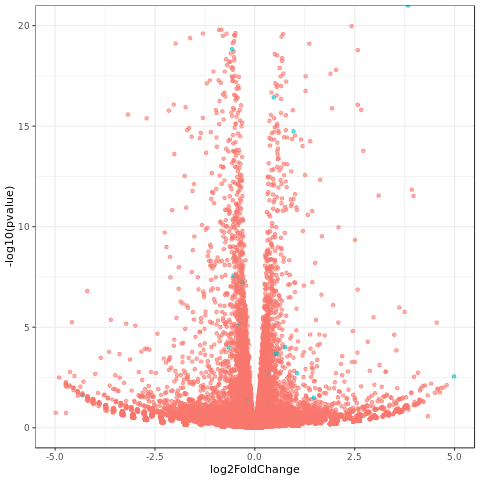

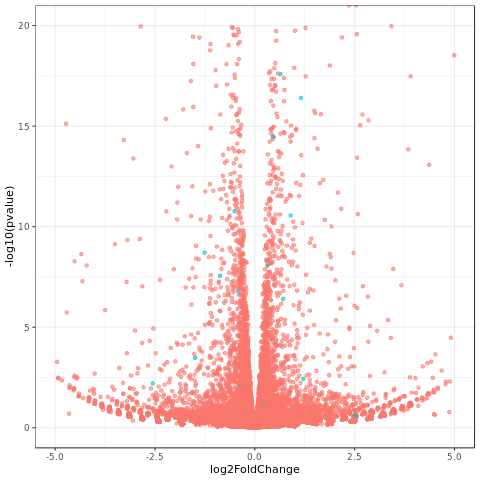

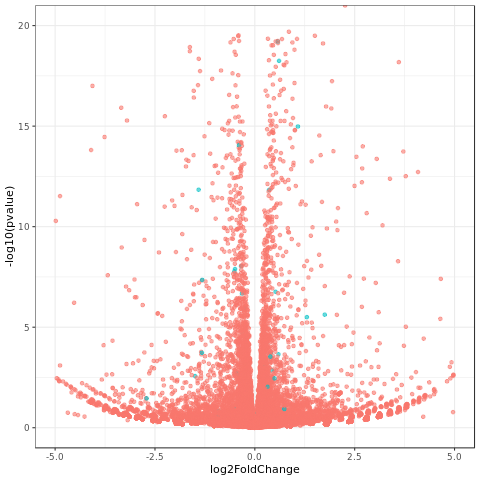

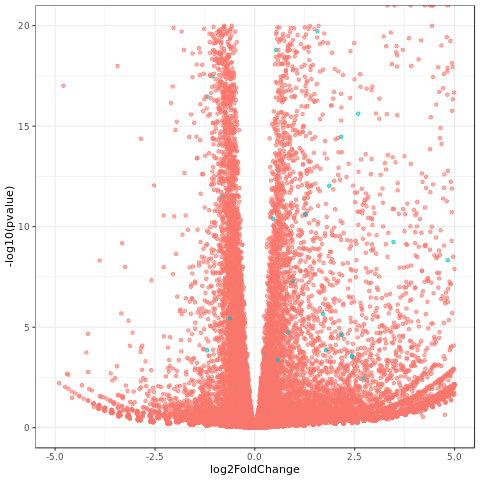

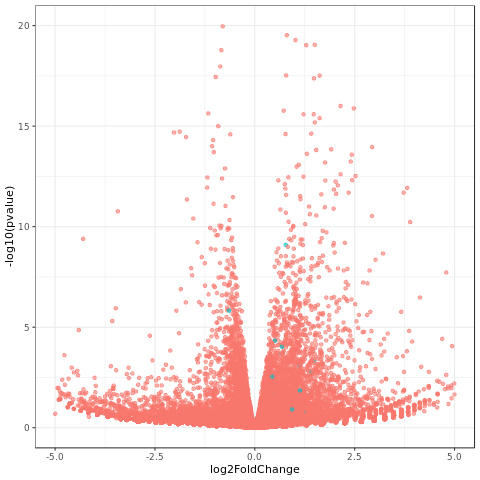

In [7]:
%%R
for (i in c(1:5)){
    model = get(paste('model',i,sep='_'))
    model_name = paste(model[1], model[2], sep ='_VS_')
    samples <- rep('skip', length(conds))
    samples[which(conds == model[1])] <- 'sample_1'
    samples[which(conds == model[2])] <- 'sample_2'
    cond <- paste(sample.type[which(samples != 'skip')], sample.cond[which(samples != 'skip')], sep="_")
    mm <- m[,which(samples != 'skip')]
    colData <- data.frame(cond, row.names=colnames(mm))
    dds <- DESeqDataSetFromMatrix(countData = mm, colData = colData, design = ~ cond)
    dds$cond <- relevel(dds$cond, ref=model[1])
    dds <- DESeq(dds)    
    # normalized counts 
    ncu <- counts(dds, normalized=TRUE)
    # Raw tabels 
    write.table(ncu, file=paste('results/model',i, model_name, "gene_count_table_DE2norm.txt", sep='_'), sep="\t", quote=FALSE, col.names=colnames(mm)) 
    write.table(mm, file=paste('results/model',i, model_name, "gene_count_table_raw.txt", sep='_'), sep="\t", quote=FALSE, col.names=colnames(mm))
    # model:
    res <- results(dds)
    write.table(res, paste('results/', paste('model',i, model_name, sep='_'), ".txt", sep=''), sep="\t", quote=FALSE, col.names=NA)
    res <- data.frame(res)
    res$type <- as.factor( row.names(res) %in% mm_set)
    relevel(res$type, ref='TRUE')
    ## Volcano plot 
    vol = res %>% ggplot(aes(x=log2FoldChange, y=-log10(pvalue), colour=type, fill=type)) + 
            geom_point(alpha = 6/10) + 
            xlim(c(-5,5)) + 
            ylim(c(0,20)) + 
            theme_bw() + 
            theme(legend.position="none")
    ggsave(paste('results/plots/model_',i,'_Volcano.pdf',sep=''), plot = vol, device = 'pdf')
    print (vol)
}

In [9]:
%%R
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   parallel  stats4    tools     stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12             refGenome_1.7.7            
 [3] RSQLite_2.1.2               doBy_4.6-3                 
 [5] EnhancedVolcano_1.2.0       ggrepel_0.8.1              
 [7] NOISeq_2.24.0               Matrix_1.2-17              
 [9] forcats